In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **BIBLIOTECAS**

In [ ]:
#pip install --upgrade tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
import tensorflow as tf
from tensorflow.keras.layers import AveragePooling2D
from keras.preprocessing import image
import keras.utils as image
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras import layers, models
from keras.utils import to_categorical

from pandas.core.algorithms import value_counts




**Folder names**

In [ ]:
#folderDrive = '/content/drive/MyDrive/TCC - Leonardo/'
folderDrive = '/content/drive/MyDrive/UFRJ/Pesquisa - Alunos/TCC Leo/TCC - Leonardo/'


**VETORIZANDO RÓTULOS**




In [ ]:
labels = ['Hid', 'Rot', 'Vel', 'Conc', 'Ext', 'Perf', 'SF']

fileNameLabel = folderDrive+'4 - Rótulos/'+'4 - Rotulos.csv'

with open(fileNameLabel, 'r') as file:
    examples = file.readlines()
    labels_all = []
    for line_num, ex in enumerate(examples, start=1):
        if line_num == 1:  # Pular a primeira linha
            continue
        label_vec = [0] * len(labels)
        for label in labels:
            if any(label in ex for label in labels):
                if label in ex:
                    idx = labels.index(label)
                    label_vec[idx] = 1
        labels_all.append(label_vec)

#print(f'labels: {labels}')
#print(labels_all)


In [ ]:
df = pd.DataFrame(labels_all) #rótulos vetorizados sem o nome das imagens
dfy = df.drop(columns = 2, axis=1) #retirar coluna 'velocidade'
df1 = pd.read_csv(fileNameLabel).drop(columns=['1','2', '3', '4', '5', '6', '7', '8']) #Deixar apenas a coluna com o nome das imagens
df2 = pd.concat([df1, df], axis=1) #rótulos vetorizados com o nome das imagens (utilizado para fazer o gráfico, com o parâmetro velocidade)
df3 = df2.drop(columns=2, axis=1) #rotulos vetorizanos sem o parametro velocidade

In [ ]:
df3

In [ ]:
print(df2[80:90])

**N.º RELATÓRIOS COM FALHA POR PARÂMETRO**

In [ ]:
#Gráfico gerado com o número de relatórios com falhas nos rótulos

parametros = ['Hid', 'Rot', 'Vel', 'Conc', 'Ext', 'PE', 'SF']
falhas = [df2[0].value_counts()[1],
          df2[1].value_counts()[1],
          df2[2].value_counts(normalize=True).get(1, 0),
          df2[3].value_counts()[1],
          df2[4].value_counts()[1],
          df2[5].value_counts()[1],
          df2[6].value_counts()[1]]

plt.bar(parametros, falhas, color = 'black')

plt.title('Falhas gráficas')
plt.xlabel('Parâmetros')
plt.ylabel('Número de falhas')
plt.show()
print(df2[1].value_counts()[1])

**TRATAMENTO DAS IMAGENS**

In [ ]:
image_directory = folderDrive+'3 - Dataset/' #Acessar o dataset


X_dataset = []
for i in tqdm(range(dfy.shape[0])): #a função tqdm cria uma barra de progresso
    img = image.load_img(image_directory +df3['filename'][i], target_size=(224, 224, 3)) #Acessar a imagem seguindo a ordem dos dados do dataframe
    img = image.img_to_array(img) #transformar em um array
    img = img/255.    #normalização
    X_dataset.append(img)

X = np.array(X_dataset)
y = np.array(dfy)




In [ ]:
print(X)

**TREINO, VALIDAÇÃO E TESTE**

In [ ]:
# Perform a stratified train-test split
X_train_, X_test, y_train_, y_test = train_test_split(X, y, random_state = 20, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_, y_train_, random_state = 20, test_size=0.2)

# Verificar o balanceamento das classes nos conjuntos de treinamento, teste e validação
from collections import Counter

print("Balanceamento das classes no conjunto de treinamento:")
print(Counter([tuple(np.where(y_train[i])[0]) for i in range(y_train.shape[0])]))

print("Balanceamento das classes no conjunto de teste:")
print(Counter([tuple(np.where(y_test[i])[0]) for i in range(y_test.shape[0])]))

print("Balanceamento das classes no conjunto de validação:")
print(Counter([tuple(np.where(y_val[i])[0]) for i in range(y_val.shape[0])]))

In [ ]:
dt = pd.DataFrame(y_train)
dt

filtro = dt[(dt[0] == 0) & (dt[1] == 0) & (dt[2] == 0) & (dt[3] == 1) & (dt[4] == 1) & (dt[5] == 0)]
filtro

**ResNet**

In [ ]:
from keras.applications.resnet50 import ResNet50

In [ ]:
EPOCHS = 200

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',
    classes=6
)

for layer in pretrained_model.layers:
        layer.trainable = False

model = models.Sequential([
    pretrained_model,

    layers.Flatten(),

    layers.Dense(512, activation='relu'),
    layers.Dense(6, activation='sigmoid')
])

model.summary()
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

checkpoint_path = "best_model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# criar um callback para salvar o peso do modelo
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only = True,
                                                 verbose=1)

history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val), batch_size=64, callbacks=[cp_callback])


94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 24639878 (93.99 MB)
Trainable params: 1052166 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Epoch 1/200
37/37 [==============================] - ETA: 0s - loss: 0.3750 -

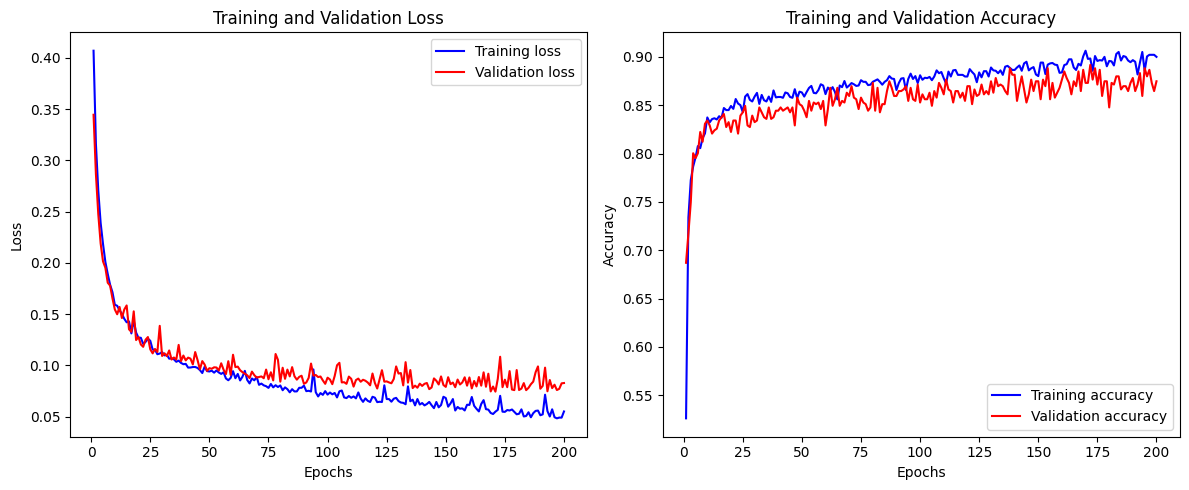

In [ ]:
# Extraia métricas de desempenho
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Crie um gráfico para visualizar o desempenho
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**PREVISÃO DO MODELO**

In [ ]:
#from pandas.io.formats.printing import PrettyDict
pdc = model.predict(X_test)

# Create an array of thresholds to try
thresholds = np.arange(0.1, 1.0, 0.01)  # Adjust the range and step size as needed

best_f1 = 0
best_threshold = 0
y_pred,y_true = pdc, y_test
# Iterate over each threshold and calculate F1-score
for threshold in thresholds:
    y_pred_binary = (y_pred > threshold).astype(int)
    f1 = f1_score(y_true, y_pred_binary, average='micro')

    # Update the best F1-score and threshold if a higher F1-score is found
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Print the best threshold and corresponding F1-score
print('Best Threshold:', best_threshold)
print('Best F1-score:', best_f1)

y_binary = (pdc > best_threshold).astype(int)
print(y_binary)
print(len(y_binary),len(y_binary[0]))

24/24 [==============================] - 32s 1s/step
Best Threshold: 0.5099999999999998
Best F1-score: 0.9232492997198879
[[0 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]
 ...
 [1 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]]
738 6


In [ ]:
xteste =

SyntaxError: ignored

##**MÉTRICAS**

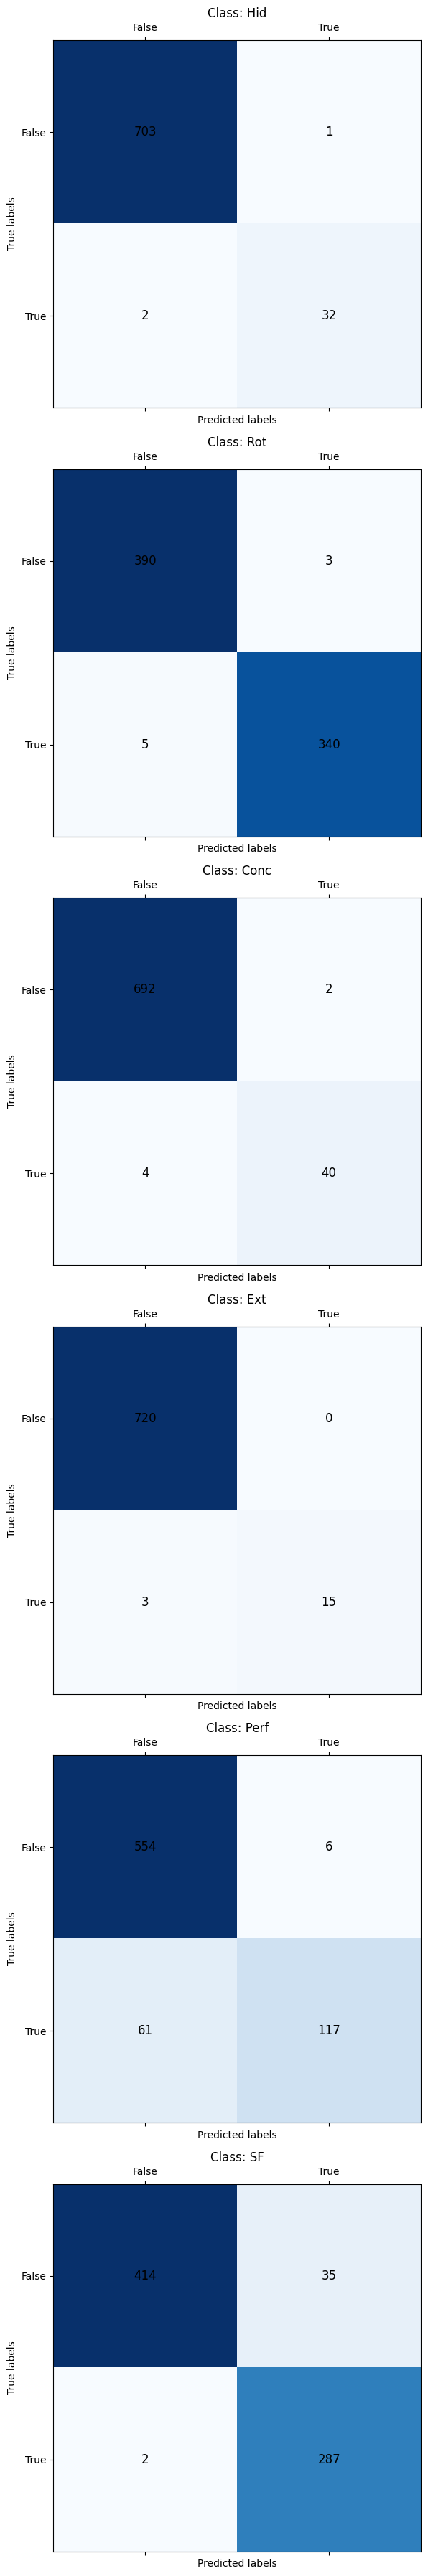

In [ ]:
caracteristicas = ['Hid', 'Rot', 'Conc', 'Ext', 'Perf', 'SF']

# Assuming you have the ground truth labels stored in y_true and the predicted labels in y_pred

# Compute the multilabel confusion matrix
cm = multilabel_confusion_matrix(y_true, y_binary)

# Plot the confusion matrix
num_classes = cm.shape[0]
fig, axes = plt.subplots(num_classes, figsize=(8, 6 * num_classes))
for i, ax in enumerate(axes):
    ax.matshow(cm[i], cmap=plt.cm.Blues)
    ax.set_title('Class: '+caracteristicas[i])
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['False', 'True'])
    ax.set_yticklabels(['False', 'True'])
    for (j, k), value in np.ndenumerate(cm[i]):
        ax.text(k, j, f'{value}', ha='center', va='center', fontsize=12)



plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

classes = ['Hid', 'Rot', 'Conc', 'Ext', 'PE', 'SF']
print(classification_report(y_test, y_binary,target_names=classes))

              precision    recall  f1-score   support

         Hid       0.97      0.94      0.96        34
         Rot       0.99      0.99      0.99       345
        Conc       0.95      0.91      0.93        44
         Ext       1.00      0.83      0.91        18
          PE       0.95      0.66      0.78       178
          SF       0.89      0.99      0.94       289

   micro avg       0.95      0.92      0.93       908
   macro avg       0.96      0.89      0.92       908
weighted avg       0.95      0.92      0.93       908
 samples avg       0.95      0.93      0.93       908



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
